In [1]:
import torch
from torch.nn.functional import mse_loss
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import matplotlib as mpl
import pandas as pd

import model.networks as networks
import model.vdm_model as vdm_model
import utils.utils as utils
import data.constants as constants

device="cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [2]:
plt.style.use(['science', 'vibrant'])
mpl.rcParams['figure.dpi'] = 300

In [23]:
def load_model(dataset = 'Astrid',
        cropsize = 128,
        gamma_min = -13.3,
        gamma_max = 13.3,
        embedding_dim = 48,
        norm_groups = 8,
        use_fourier_features = False,
        add_attention = False,
        noise_schedule = 'learned_linear',
        n_blocks = 4
):
    vdm = vdm_model.LightVDM(
            score_model=networks.UNetVDM(
                gamma_min=gamma_min,
                gamma_max=gamma_max,
                embedding_dim=embedding_dim,
                norm_groups=norm_groups,
                n_blocks=n_blocks,
                add_attention=add_attention,
                use_fourier_features=use_fourier_features
            ),
            dataset=dataset,
            gamma_min=gamma_min,
            gamma_max=gamma_max,
            image_shape=(1,128,128,128),
            noise_schedule=noise_schedule,
        )
    vdm = vdm.to(device=device)
    vdm = vdm.eval()
    
    ckpt = '/opt/data/private/wangjuntong/code/redshift/debiasing_redshift_0to1/e64e296441fa43d0a5e4cd0782de5fc8/checkpoints/epoch=513-step=3084-val_loss=1.003.ckpt'
    state_dict=torch.load(ckpt)["state_dict"]
    vdm.load_state_dict(state_dict)
    return vdm.eval()

In [24]:
vdm = load_model()

In [25]:
# Load data
mass_mstar = np.load('Grids_Mcdm_IllustrisTNG_1P_128_z=0.0.npy')
mass_cdm = np.load('Grids_Mcdm_IllustrisTNG_1P_128_z=1.0.npy')
mass_mstar = np.log10(mass_mstar+1)
mass_cdm = np.log10(mass_cdm)

mean_input = constants.norms['Astrid'][0]
std_input = constants.norms['Astrid'][1]
mean_target = constants.norms['Astrid'][2]
std_target = constants.norms['Astrid'][3]

mass_mstar_normed = torch.Tensor((mass_mstar - mean_input) / std_input).unsqueeze(1).unsqueeze(1)
mass_cdm_normed = torch.Tensor((mass_cdm - mean_target) / std_target).unsqueeze(1).unsqueeze(1)

In [26]:
# selected indices for each parameter
selected = [[3, 7], [25, 29], [36, 40],]

param_indices = [idx for sublist in selected for idx in sublist]
indices = [idx  for sublist in selected for idx in sublist]

In [27]:
selected = [3]

param_indices = [3]
indices = [3]

In [28]:
labels = [r'$\Omega_m$', r'$A_\mathrm{SN1}$', r'$A_\mathrm{AGN1}$',]
plot_names = ['Omega_m', 'A_SN1', 'A_AGN1',]
names = ['Omega_m', 'sigma_8', 'A_SN1', 'A_AGN1', 'A_SN2', 'A_AGN2']
params = pd.read_csv('params_1P_IllustrisTNG.txt', sep=' ', header=None, names=names)

In [29]:
def generate_samples(conditioning, batch_size=1, n=1500):

    star = conditioning[0]
    star_fields = star.expand(batch_size, star.shape[0], star.shape[1], star.shape[2],star.shape[3])

    maps = [] # 10 tensors of shape ([10, 1, img_shape, img_shape])
    # draw n samples with the same conditioning
    for i in range(n):
        sample = vdm.draw_samples(
            conditioning=star_fields,
            batch_size=batch_size,
            n_sampling_steps=vdm.hparams.n_sampling_steps,
            )
        maps.append(sample)
        print(i)

        
    return maps

In [30]:
selected = [3]

param_indices = [3]
indices = [3]

device = "cuda:0" if torch.cuda.is_available() else "cpu"
generated_maps = []

# Ensure your model is on the correct device (assuming `vdm` is your model)
vdm.to(device)


for idx in indices:
    print(idx)
    # Make sure conditioning tensor is on the correct device
    conditioning_tensor = mass_mstar_normed[idx].to(device)
    generated_maps.append(
        torch.vstack(generate_samples(conditioning=conditioning_tensor,batch_size=1, n=1500)).to(device)
    )

# Assuming std_target and mean_target are scalars or already on the correct device
generated_maps = torch.stack(generated_maps).to(device) * std_target + mean_target


3


In [ ]:
torch.save(generated_maps, 'generated_more_maps_2.pt')

In [ ]:
generated_maps.shape

In [9]:
import torch
from torch.nn.functional import mse_loss
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import matplotlib as mpl
import pandas as pd

import model.networks as networks
import model.vdm_model as vdm_model
import utils.utils as utils
import data.constants as constants



In [10]:
len(g)

1

In [10]:
# Load data
mass_mstar = np.load('Grids_Mcdm_IllustrisTNG_1P_128_z=0.0.npy')
mass_cdm = np.load('Grids_Mcdm_IllustrisTNG_1P_128_z=1.0.npy')
mass_mstar = np.log10(mass_mstar + 1)
mass_cdm = np.log10(mass_cdm + 1)

# 从constants中获取归一化参数
mean_input = constants.norms['Astrid'][0]
std_input = constants.norms['Astrid'][1]
mean_target = constants.norms['Astrid'][2]
std_target = constants.norms['Astrid'][3]

# 将numpy数组转换为torch张量，并应用归一化
# 注意unsqueeze操作可能不再需要，因为3D数据已经具有额外的深度维度
mass_mstar_normed = torch.Tensor((mass_mstar - mean_input) / std_input).unsqueeze(1)
mass_cdm_normed = torch.Tensor((mass_cdm - mean_target) / std_target).unsqueeze(1)

# 确保张量的形状正确，这里应该是 (N, C, D, H, W)，其中C=1表示单通道
print("Mass mstar normed shape:", mass_mstar_normed.shape)
print("Mass cdm normed shape:", mass_cdm_normed.shape)

Mass mstar normed shape: torch.Size([61, 1, 128, 128, 128])
Mass cdm normed shape: torch.Size([61, 1, 128, 128, 128])


In [11]:
halos = {
    (50, 89,63) : 5,
    (50, 46,63) : 4,
    (8, 38,63) : 5,
    (60, 37,63) : 4,
    (18, 92,63) : 7,
}

In [12]:
X, Y ,Z= np.ogrid[:128, :128,:128]
true_masses = []
masks = []
for center, radius in halos.items():
    distance = np.sqrt((X-center[0])**2+(Y-center[1])**2+(Z-center[2])**2)
    cdm_mass = mass_cdm[0].squeeze()
    mask = distance <= radius
    masks.append(mask)
    masked = cdm_mass.copy()
    masked[~mask] = 0
    true_masses.append(np.sum(10 ** masked))

In [13]:
colors = ['#935083', '#FB8B6F', '#FFBE62', '#D16580','#00C89E']

In [8]:
mass_mstar.shape

(61, 128, 128, 128)

In [ ]:
ppp=torch.load('/opt/data/private/wangjuntong/code/redshift/result2/40.pt')

In [ ]:
ggg = torch.cat(ppp, dim=0)

In [ ]:
ggg.shape

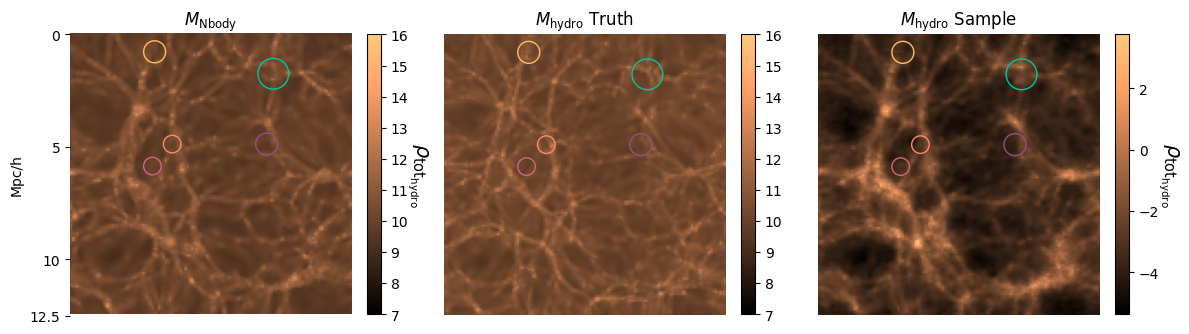

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
mass_mstar_selected = mass_mstar[0].squeeze()
# Select a middle slice from the 3D volume, here the 64th slice along the z-axis
slice_index = 63
fig, axes = plt.subplots(1,3, figsize=(12,4))

img = axes[0].imshow(mass_mstar[0, :, :,44], cmap='copper',vmin=7,vmax=16)  # Adjusted for correct indexing
cbar = fig.colorbar(img, ax=axes[0], fraction=0.045)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r"$\rho_{\mathrm{tot_{hydro}}}$", rotation=270, fontsize=15)

img = axes[1].imshow(mass_cdm[0, :, :,44], cmap='copper',vmin=7,vmax=16)
fig.colorbar(img, ax=axes[1], fraction=0.045)

img = axes[2].imshow(ggg[0, 0,:,:,44].cpu(), cmap='copper')
cbar = fig.colorbar(img, ax=axes[2], fraction=0.045)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\rho_{\mathrm{tot_{hydro}}}$', rotation=270, fontsize=15)

for i, (center, radius) in enumerate(halos.items()):
    axes[0].add_patch(Circle((center[1], center[0]), radius,
             edgecolor = colors[i], 
             fill=False,
             lw=1))
    axes[1].add_patch(Circle((center[1], center[0]), radius,
             edgecolor = colors[i],
             fill=False,
             lw=1))
    axes[2].add_patch(Circle((center[1], center[0]), radius,
             edgecolor = colors[i],
             fill=False,
             lw=1))

axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xticks([])
axes[0].set_yticks([0., 51.2, 102.4, 128], labels=["0", "5", "10", "12.5"])
axes[0].set_ylabel("Mpc/h")        
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title(r"$M_{\mathrm{Nbody}}$")
axes[1].set_title(r"$M_{\mathrm{hydro}}$ Truth")
axes[2].set_title(r"$M_{\mathrm{hydro}}$ Sample") 
plt.tight_layout()

In [6]:
ppp=torch.load('/opt/data/private/wangjuntong/code/redshift/result2/40.pt')

In [7]:
ggg = torch.cat(ppp, dim=0)

In [8]:
ggg.shape

torch.Size([480, 1, 128, 128, 128])